In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform                

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': #맥os 사용자의 경우
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')

In [2]:
import os

In [7]:
!pip install xlrd

     |████████████████████████████████| 103 kB 257 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In [3]:
ls

2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx
2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터.xlsx
2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx
Untitled.ipynb


# 2019 실적데이터
-  취급액 =판매단가 X  주문량(취소,반품제외) 
- 판매가  0원(무형상품)은추정 제외 
- 매주 토요일  18:00~18:20은 정보방송시간으로 추정 제외(당사사정에 따라 ±20 편성 변경 있음)

- 편성 듀레이션은  10분~60분내외 임 

- 2020.06월 편성표는 월~토 6:20~2:20(익일), 일요일은 6:20~2:00로 구성 (심야시간대 제외)

- 단, raw data의 19.01.01~19.10.31은 6:00~2:00로 운영하였음 11.01부터 6:20~2:20운영

In [10]:
sil=pd.read_excel('2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터.xlsx'
              , sheet_name='rawdata_2019(완)', header=1)

### 결측값 처리
- 방송일시, 마더코드로 그룹바이→ 노출 ffill
- 판매 단가, 취급액이 null값이면 제외
- 데이터에서 50000.0으로 찍힌 것들은 에러 → 0으로 처리해서 분석할 것(빅콘 피셜)

In [24]:
#방송일시, 마더코드로 그룹바이→ 노출 ffill
sil['노출(분)']=sil.groupby(['방송일시','마더코드']).ffill()['노출(분)']

In [28]:
sil.isna().sum()

방송일시       0
노출(분)    253
마더코드       0
상품코드       0
상품명        0
상품군        0
판매단가       0
취급액      937
방송일        0
방송시간       0
dtype: int64

In [31]:
#판매 단가, 취급액이 null값이면 제외
sil=sil.dropna(subset=['취급액'])

In [35]:
# 데이터에서 50000.0으로 찍힌 것들은 에러 → 0으로 처리해서 분석할 것(빅콘 피셜)
sil[sil['취급액']==50000]['취급액']=0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Feature 추가

### 방송일/ 시간

In [15]:
sil['방송일시']=sil['방송일시'].astype(str)

In [17]:
sil['방송일']=sil['방송일시'].apply(lambda row: row.split(' ')[0])
sil['방송시간']=sil['방송일시'].apply(lambda row: row.split(' ')[1])

### 주문량
- 취급액 =판매단가 X 주문량(취소,반품제외)

In [43]:
def div(x,y):
    if y==0:
        return np.nan
    else:
        return x/y
    
sil['주문량']=sil.apply(lambda row: round(div(row['취급액'],row['판매단가'])),axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [45]:
sil.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,방송일,방송시간,주문량
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,06:00:00,53
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,06:00:00,110
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,06:20:00,82
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,06:20:00,174
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,06:40:00,167


### 카테고리 별 분류 DataFrame 생성

In [50]:
cat_df=sil.groupby('마더코드')['상품명'].agg(list).reset_index()

In [65]:
cat_df['상품명']=cat_df['상품명'].apply(lambda row: list(set(row)))

In [169]:
def doubleList(li):
    #같은 마더코드를 가지고 있는 상품을 이중 리스트로 저장
    big_temp=[]
    for j in range(len(li)):
        temp=[]
        for i in range(len(li[j])):
            temp.append(li[j][i])
        big_temp.append(temp)
    return big_temp

In [170]:
def commonString(big_temp):
    #같은 마더코드 내에서, 공통된 string만 뽑아낸다
    common=[]
    for i in range(len(big_temp)):
        for j in range(len(big_temp[i]),0,-1):
                try:
                    if big_temp[i][j]==big_temp[i+1][j]:
                        common.append(big_temp[i][j])
                except: 
                    pass
    common.reverse()
    return common

In [188]:
def handling(row,y):
    if len(row)==0:
        return y
    else: 
        return ''.join(row)

In [189]:
cat_df['카테고리']=cat_df.apply(lambda row: handling(commonString(doubleList(row['상품명'])), row['상품명']), axis=1)

In [190]:
cat_df

,마더코드,상품명,카테고리
0,100000,[엘로엘 아쿠아클린 마스크],[엘로엘 아쿠아클린 마스크]
1,100001,[국내생산 스텐락 심플 스텐밀폐용기 17종],[국내생산 스텐락 심플 스텐밀폐용기 17종]
2,100002,[이보은의 우삽겹 12팩세트],[이보은의 우삽겹 12팩세트]
3,100006,"[AAA 19 F/W 남성 트레킹화 3종, AAA 19 F/W 여성 트레킹화 3종]",AA 19 F/W 성 트레킹화 3종
4,100009,[AAB의 든든한 콩국수],[AAB의 든든한 콩국수]
...,...,...,...
682,100843,"[일시불 도깨비그릴, 무이자 도깨비그릴]",도깨비그릴
683,100844,"[하늘내린 용대리황태10미, 하늘내린 용대리황태10마리]",늘내린 용대리황태10
684,100845,"[알비에로 마르티니 1A클라쎄 지오맵 호보백, 알비에로 마르티니 1A클라쎄 스퀘어 ...",비에로 마르티니 1A클라쎄 지오맵 라이트비에로 마르티니 1A클라쎄 지오비에로 마르티...
685,100846,[알비에로 마르티니 1A클라쎄 지오맵 울실크 스카프],[알비에로 마르티니 1A클라쎄 지오맵 울실크 스카프]


In [269]:
sil.groupby('상품군').count()

,방송일시,노출(분),마더코드,상품코드,상품명,판매단가,취급액,방송일,방송시간,주문량
상품군,,,,,,,,,,
가구,2614,2614,2614,2614,2614,2614,2614,2614,2614,2614
가전,6479,6479,6479,6479,6479,6479,6479,6479,6479,6479
건강기능,790,790,790,790,790,790,790,790,790,790
농수축,3884,3884,3884,3884,3884,3884,3884,3884,3884,3884
생활용품,2877,2877,2877,2877,2877,2877,2877,2877,2877,2877
속옷,3919,3919,3919,3919,3919,3919,3919,3919,3919,3919
의류,4340,4258,4340,4340,4340,4340,4340,4340,4340,4340
이미용,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305
잡화,3891,3720,3891,3891,3891,3891,3891,3891,3891,3891


### 방송 시간대/ 일별 시각화

### 1) 방송 일별 판매단가, 취급액, 주문량 분포 -> 월별 추세를 통해 살펴본다

In [203]:
dic={'판매단가':'mean', '취급액':'mean','주문량':'sum'}
data=sil.groupby(['방송일']).agg(dic).reset_index()

<AxesSubplot:xlabel='방송일', ylabel='취급액'>

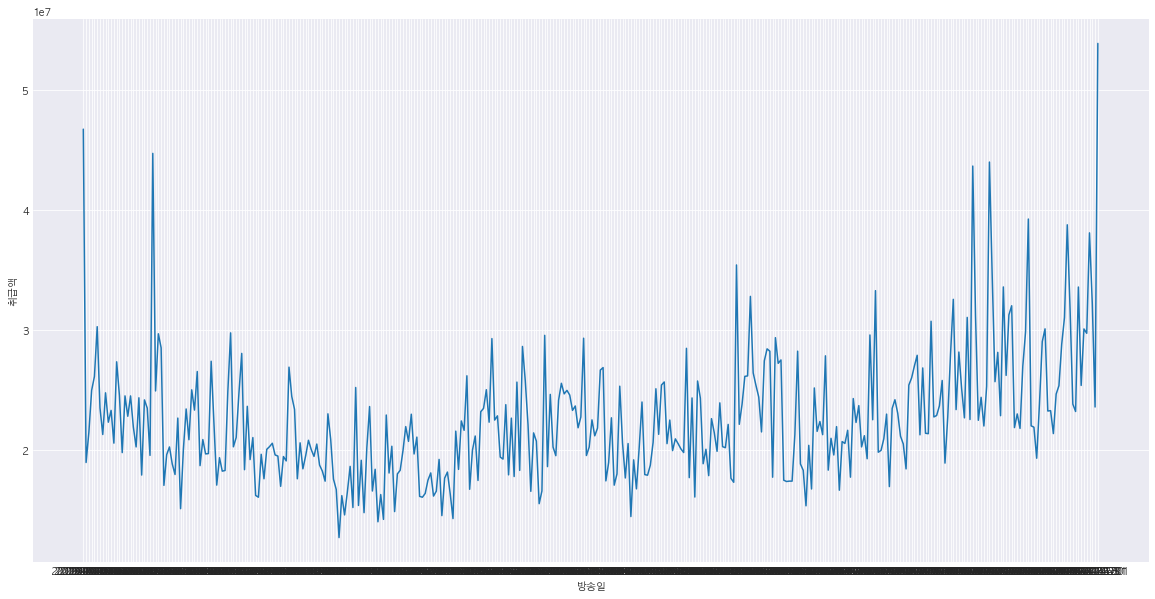

In [254]:
#2019/01/01~2020/12/30 까지의 취급액 살펴본것-> 추세를 살펴보기 힘들어서, 잘라서 살펴보기로 함
f, ax = plt.subplots(1,1,figsize=(20,10))
sns.lineplot(x='방송일',y='취급액',data=data)

<AxesSubplot:xlabel='방송일', ylabel='주문량'>

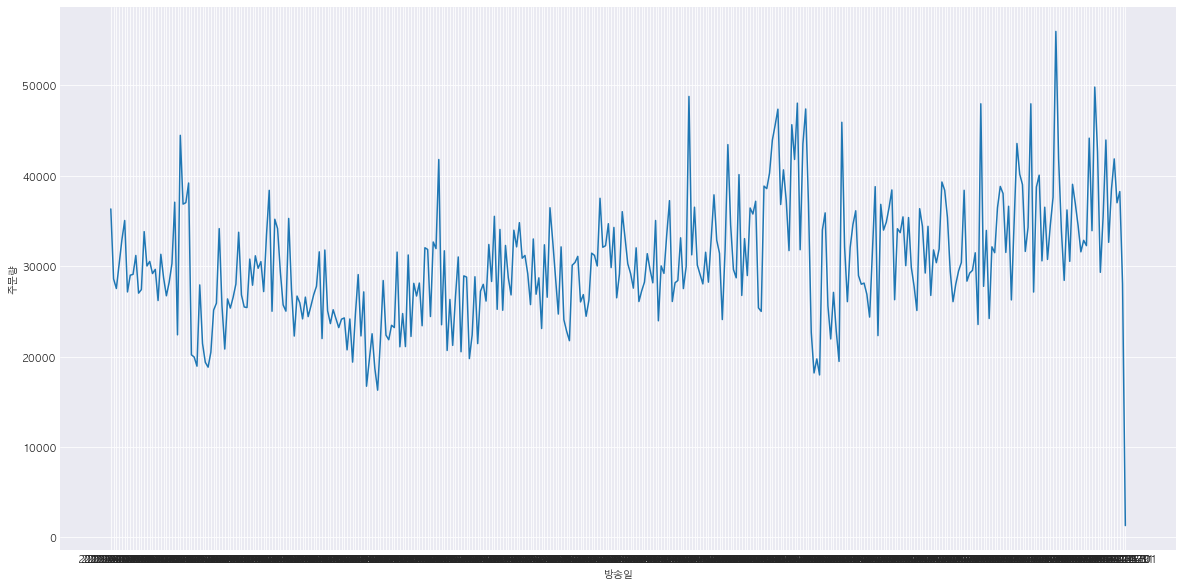

In [252]:
#2019/01/01~2020/12/30 까지의 주문량 살펴본것-> 추세를 살펴보기 힘들어서, 잘라서 살펴보기로 함
f, ax = plt.subplots(1,1,figsize=(20,10))
sns.lineplot(x='방송일',y='주문량',data=data)

In [ ]:
#한달의 시작일과 종료일을 설정-> 월별 추세를 살펴보기 위해 split
start_idx=data[pd.to_datetime(data['방송일']).dt.is_month_start==True].index
end_idx=data[pd.to_datetime(data['방송일']).dt.is_month_end==True].index

month_names=[]
for i in range(12):
    month_names.append('month{}'.format(i+1))
    
k=0
for i,j in zip(start_idx,end_idx):
    globals()[month_names[k]]=data.iloc[i:j,:]
    k+=1

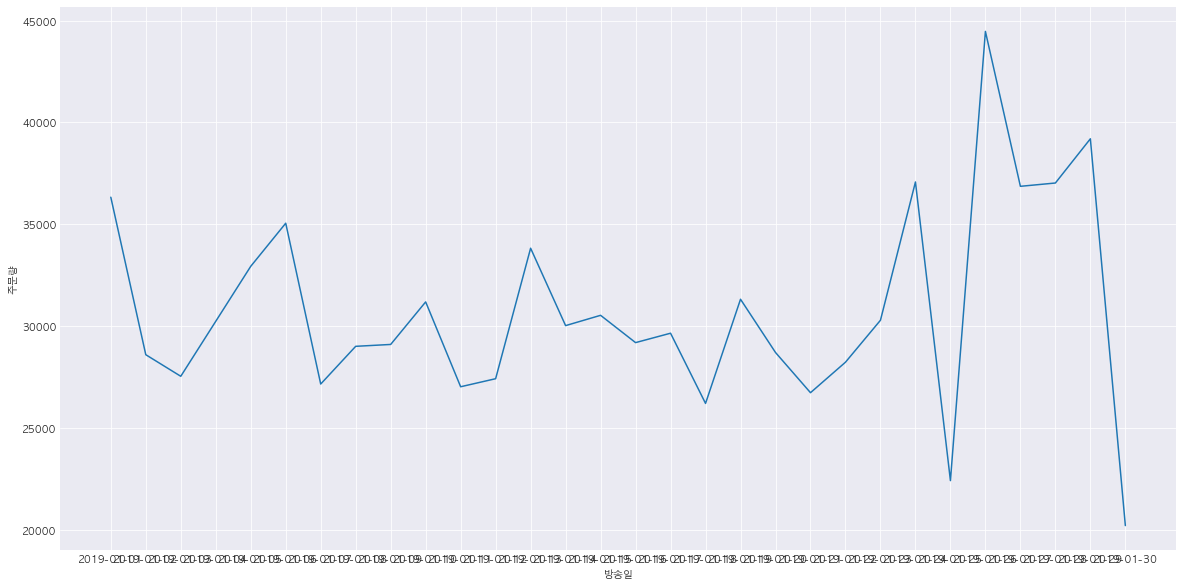

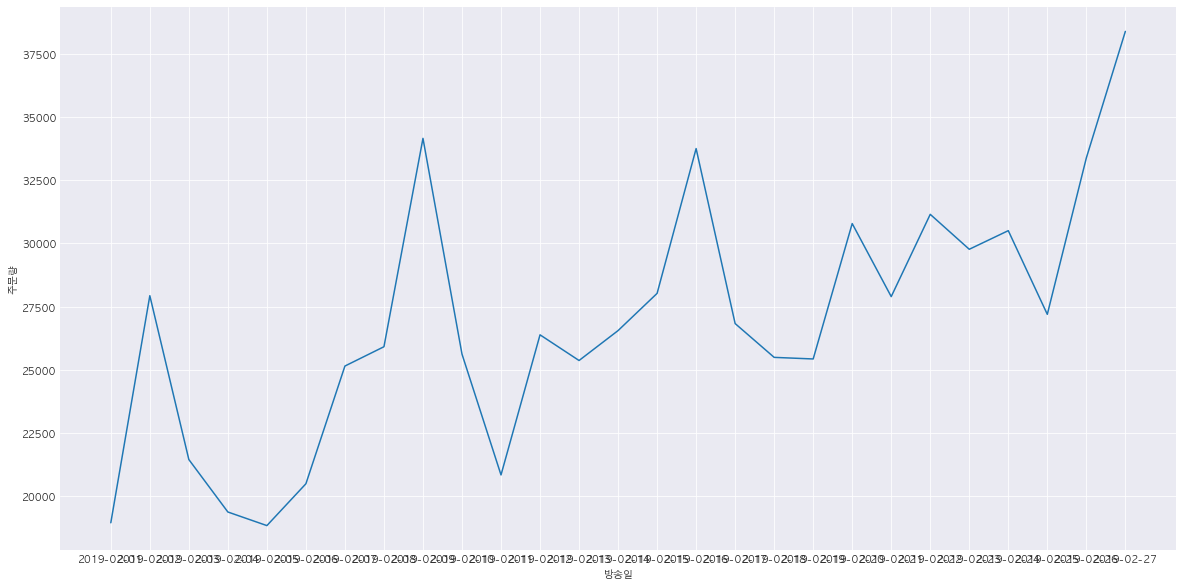

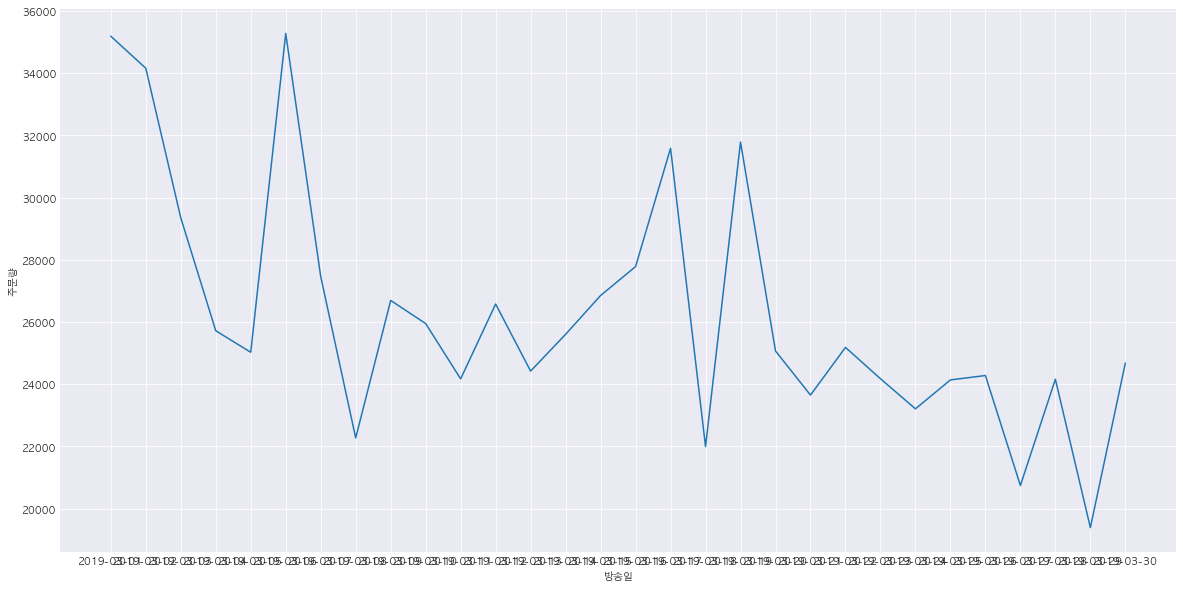

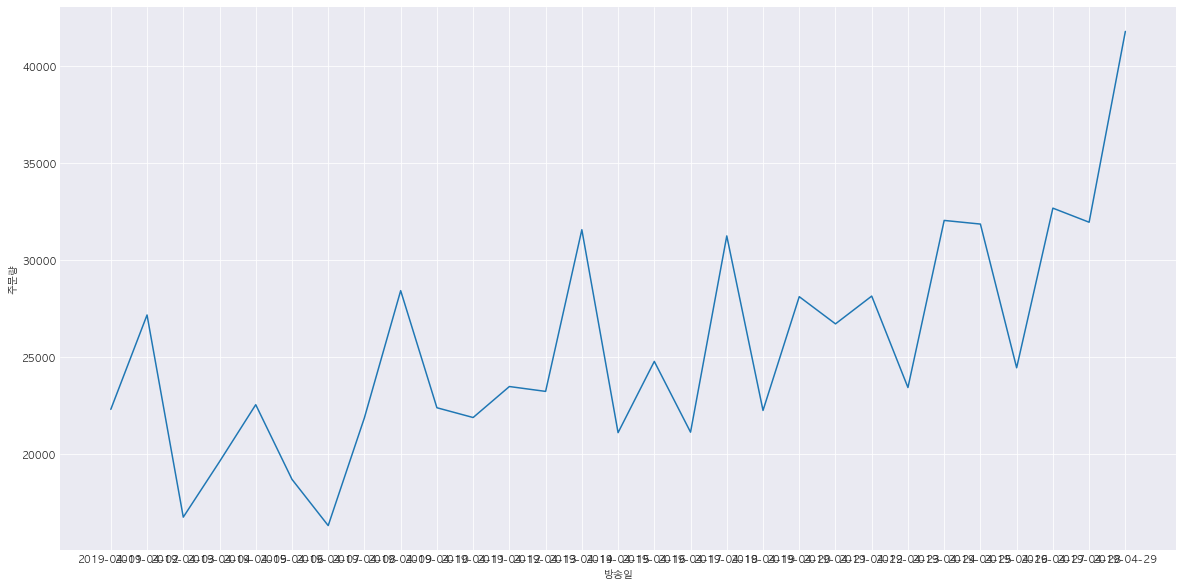

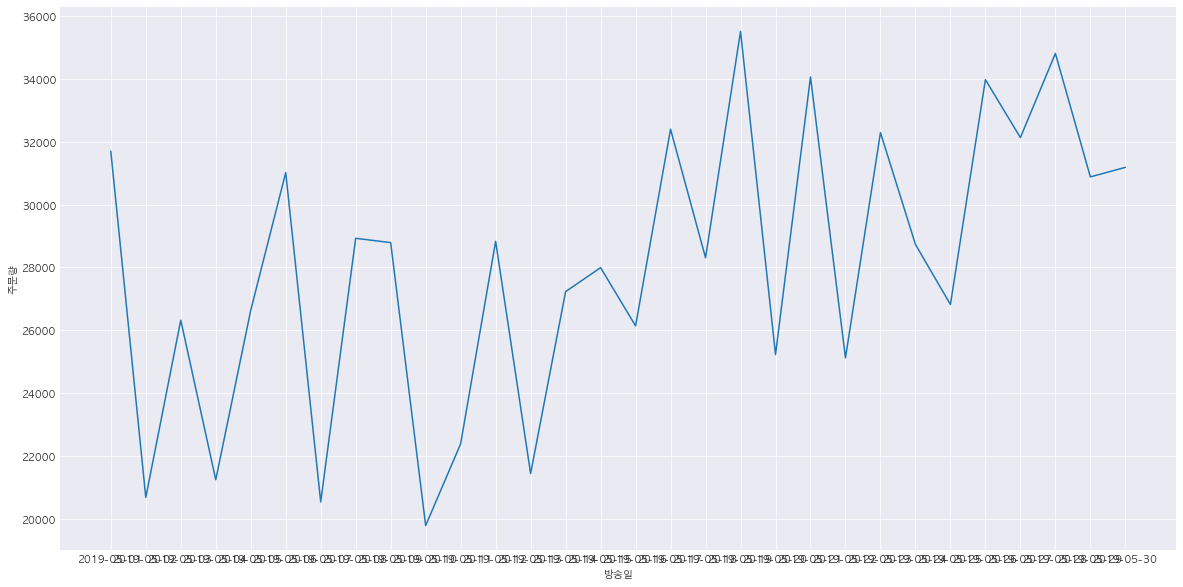

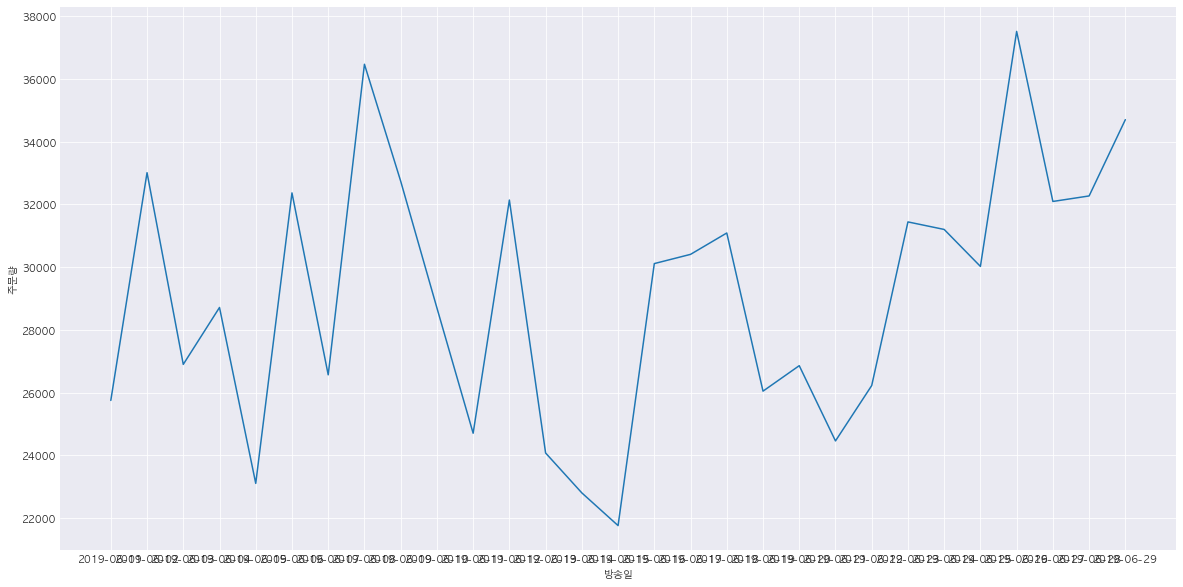

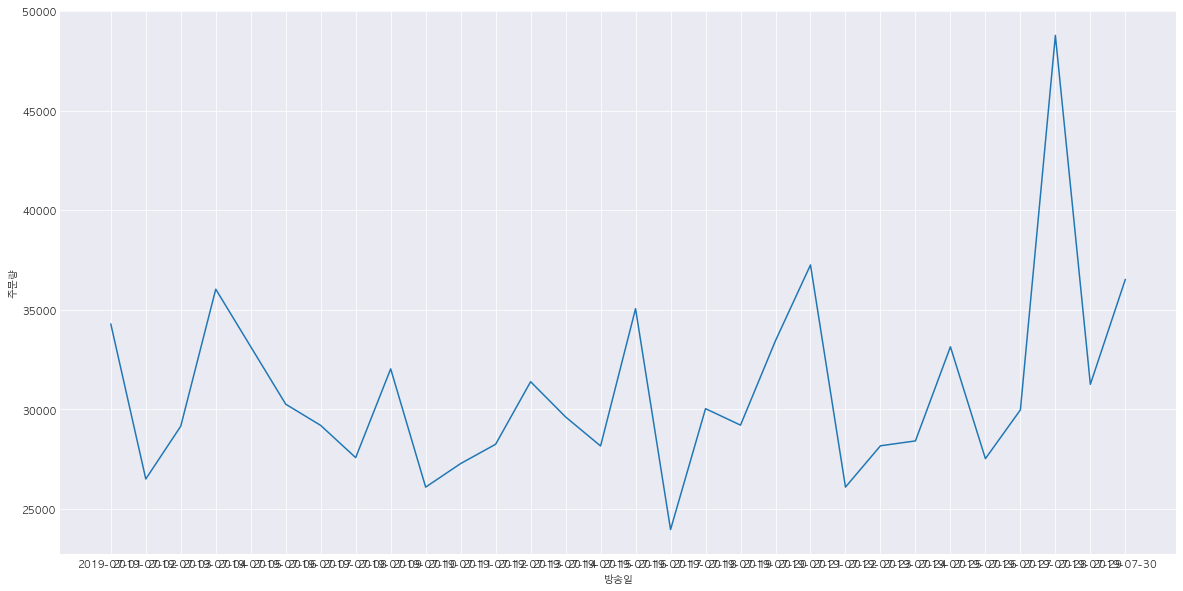

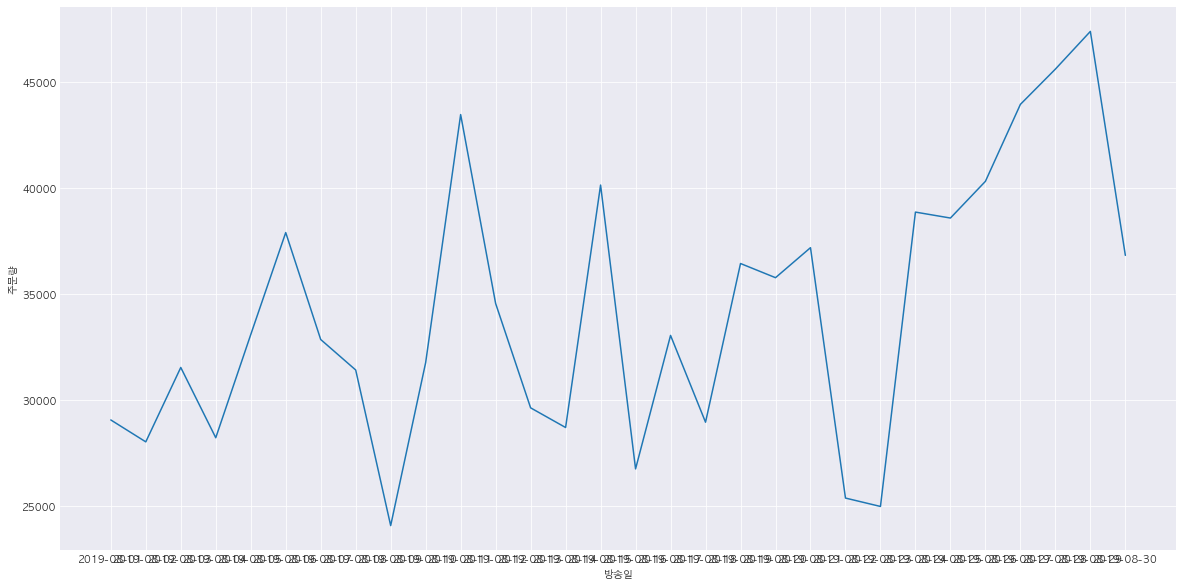

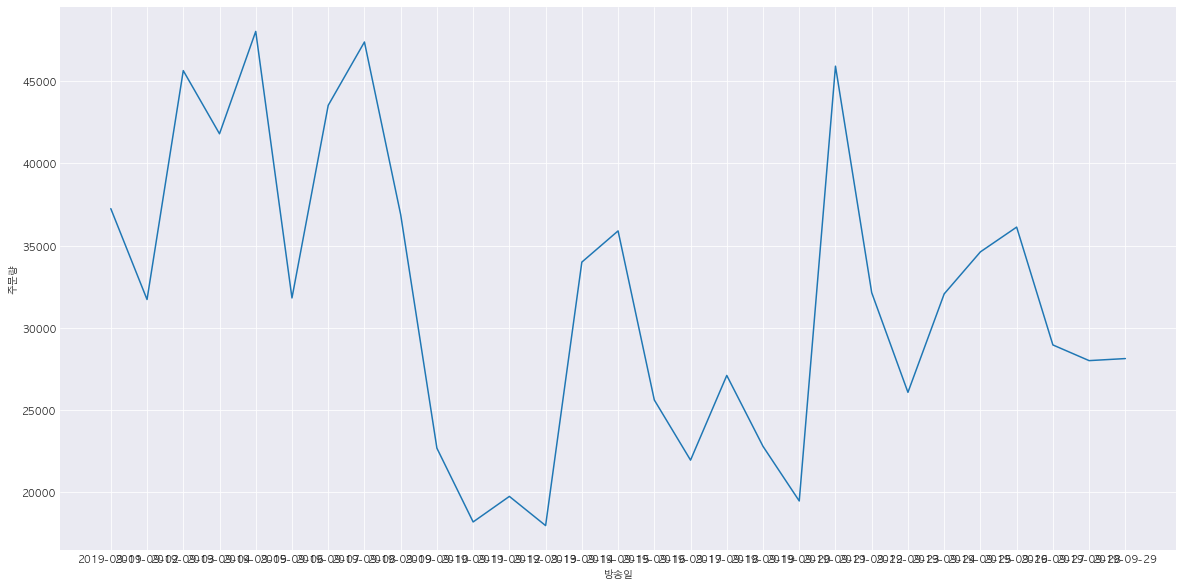

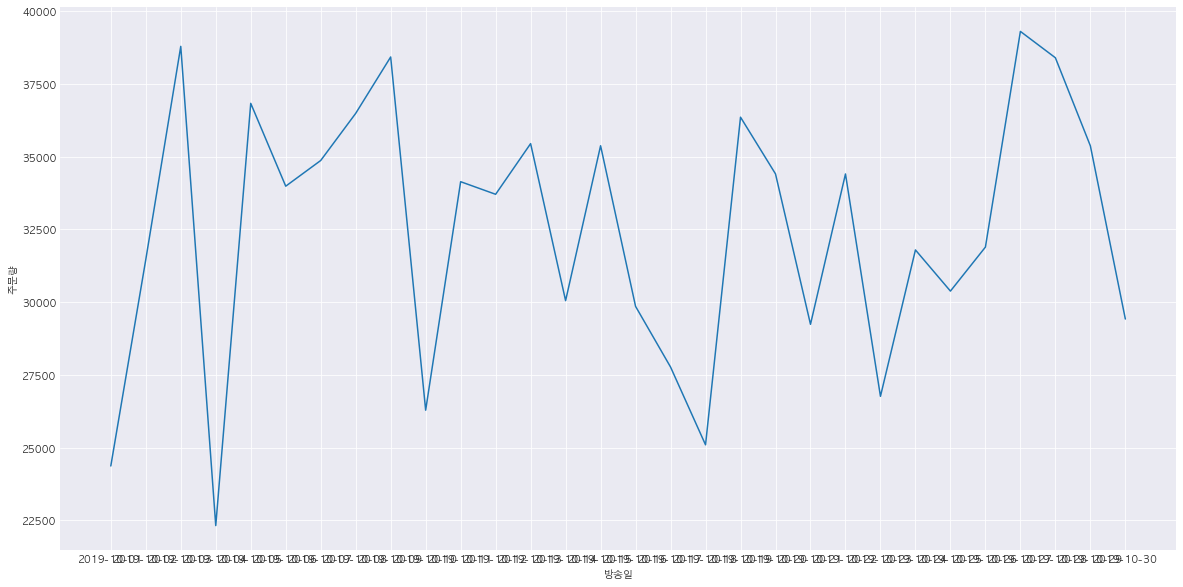

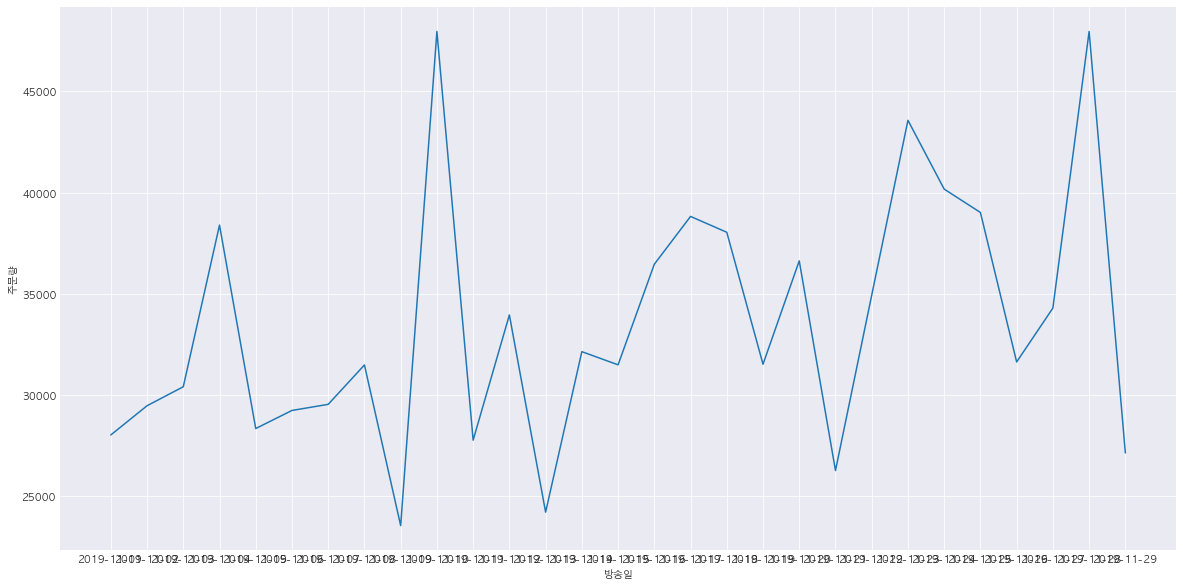

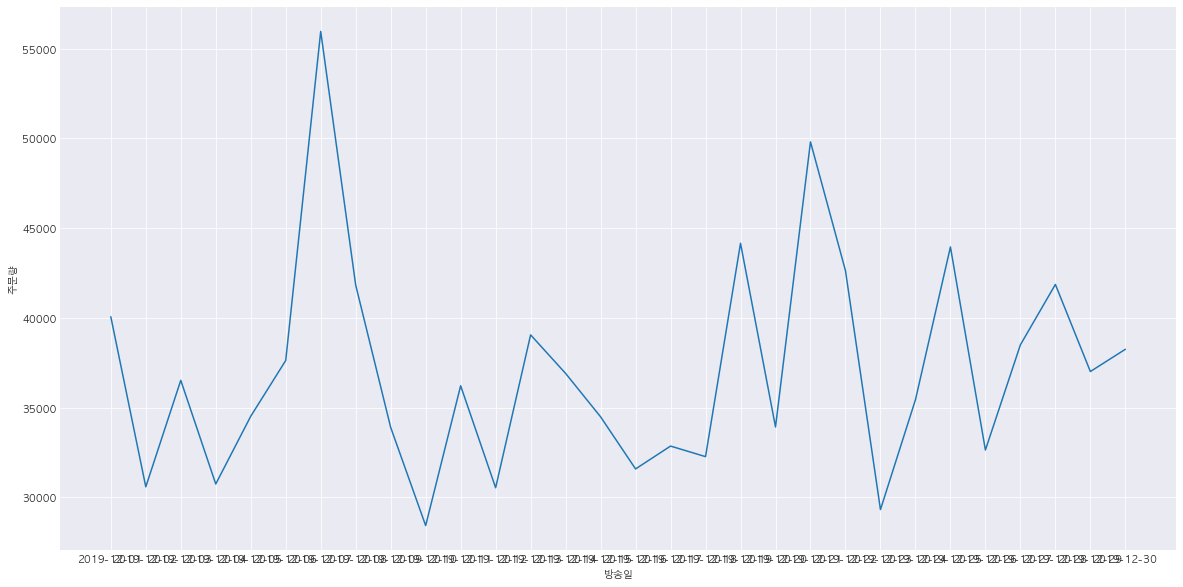

In [253]:
#월 별 추세 살펴보기
for i in range(12):
    monthly_data=globals()[month_names[i]]
    f, ax = plt.subplots(1,1,figsize=(20,10))
    sns.lineplot(x='방송일',y='주문량',data=monthly_data)

### 2) 시간대별 분포

In [257]:
data2=sil[sil['방송일']=='2019-08-09']

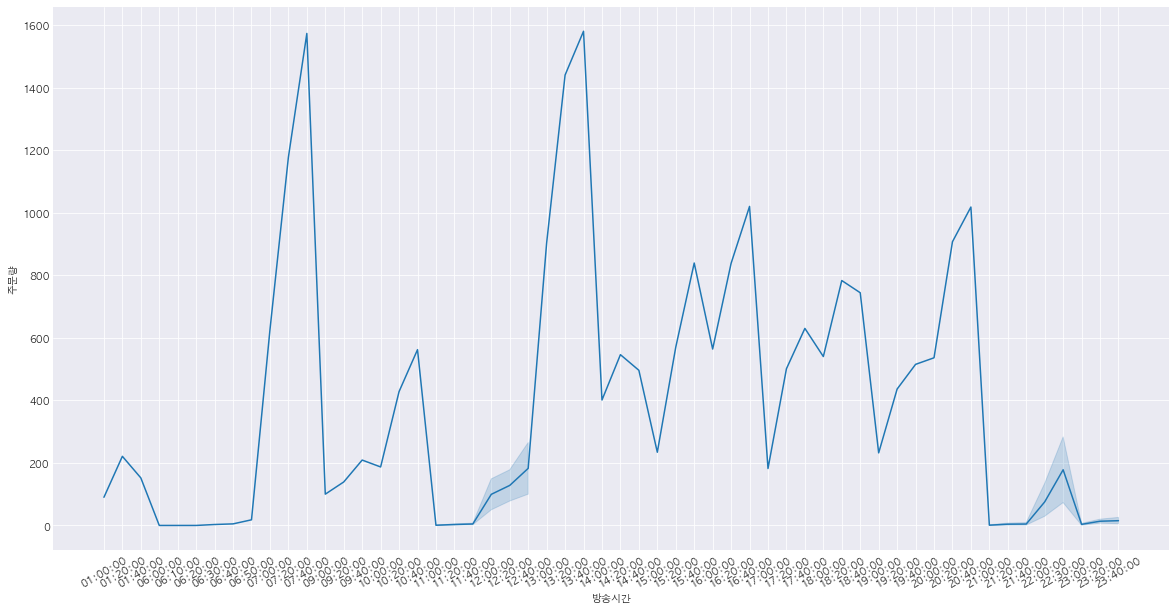

In [263]:
f, ax = plt.subplots(1,1,figsize=(20,10))
sns.lineplot(x='방송시간', y='주문량',data=data2)
plt.xticks(rotation=30)
plt.show()
#아침 7시에 이렇게 주문을 많이 한다고...?
#1시

# 시청률 데이터

In [266]:
pd.read_excel('2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx', header=1)

,시간대,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,...,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2019-01-01 to 2019-12-31
0,02:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003
1,02:01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.003
2,02:02,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004
3,02:03,0.000,0.000,0.014,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.004
4,02:04,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,01:56,0.000,0.000,0.000,0.000,0.027,0.000,0.000,0.000,0.000,...,0.013,0.000,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.004
1437,01:57,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,...,0.013,0.000,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.004
1438,01:58,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,...,0.013,0.017,0.000,0.000,0.015,0.000,0.000,0.019,0.000,0.004
1439,01:59,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,...,0.013,0.000,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.004


In [ ]:
시청률 계산을 어떻게 하는지 살펴보자